# **Audio Latent Space Clustering and Visualization**

This project demonstrates how to perform **K-Means clustering** on latent features extracted from a **Variational Autoencoder (VAE)** trained on audio data. It also visualizes the clusters in 2D using **t-SNE**.


In [2]:
# Library Imports
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
from pathlib import Path
import librosa
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score
import os
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import adjusted_rand_score

In [2]:
# Mel-spectrogram extraction
def extract_mel(path, n_mels=64, fixed_len=1304):
    y, sr = librosa.load(path, sr=22050)
    mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, hop_length=512)
    mel = np.log(mel + 1e-9)
    mel = (mel - mel.min()) / (mel.max() - mel.min() + 1e-9)
    if mel.shape[1] < fixed_len:
        pad_width = fixed_len - mel.shape[1]
        mel = np.pad(mel, ((0,0),(0,pad_width)), mode='constant')
    else:
        mel = mel[:, :fixed_len]
    return torch.tensor(mel, dtype=torch.float32)

In [3]:
# Dataset
class AudioDataset(Dataset):
    def __init__(self, audio_files, fixed_len=1304):
        self.audio_files = audio_files
        self.fixed_len = fixed_len

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        mel = extract_mel(self.audio_files[idx], fixed_len=self.fixed_len)
        return mel.unsqueeze(0)

In [4]:
# VAE model (encoder only)
class VAE(torch.nn.Module):
    def __init__(self, latent_dim=32, fixed_len=1304, n_mels=64):
        super().__init__()
        self.n_mels = n_mels
        self.fixed_len = fixed_len

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, 3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(16, 32, 3, stride=2, padding=1),
            torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, 3, stride=2, padding=1),
            torch.nn.ReLU(),
        )

        dummy_input = torch.zeros(1, 1, n_mels, fixed_len)
        h = self.encoder(dummy_input)
        self.enc_shape = h.shape[1:]
        self.flattened_size = h.numel() // h.shape[0]

        self.fc_mu = torch.nn.Linear(self.flattened_size, latent_dim)
        self.fc_logvar = torch.nn.Linear(self.flattened_size, latent_dim)

    def encode(self, x):
        h = self.encoder(x)
        h = h.view(h.size(0), -1)
        return self.fc_mu(h), self.fc_logvar(h)


In [5]:
# Load trained VAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
latent_dim = 32
fixed_len = 1304

vae_model = VAE(latent_dim=latent_dim, fixed_len=fixed_len).to(device)

# Load state dict and ignore extra keys
state_dict = torch.load(r"E:\CSE425_Project\project\results\models\audio_vae.pth", map_location=device)
filtered_dict = {k: v for k, v in state_dict.items() if k in vae_model.state_dict()}
vae_model.load_state_dict(filtered_dict, strict=False)
vae_model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
  (fc_mu): Linear(in_features=83456, out_features=32, bias=True)
  (fc_logvar): Linear(in_features=83456, out_features=32, bias=True)
)

In [6]:
# Load audio files
audio_dir = Path("../data/audio")
audio_files = sorted(audio_dir.glob("*/*.mp3"))
dataset = AudioDataset(audio_files, fixed_len=fixed_len)
loader = DataLoader(dataset, batch_size=16, shuffle=False)

In [7]:
# Extract latent features
latent_features = []
file_paths = []

with torch.no_grad():
    for batch_idx, batch in enumerate(loader):
        batch = batch.to(device)
        mu, logvar = vae_model.encode(batch)
        latent_features.append(mu.cpu().numpy())
        file_paths.extend(audio_files[batch_idx*loader.batch_size : batch_idx*loader.batch_size + batch.size(0)])

latent_features = np.vstack(latent_features)
print("Latent features shape:", latent_features.shape)

Latent features shape: (3554, 32)


In [8]:
# K-Means clustering
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(latent_features)
print("Clusters assigned.")

Clusters assigned.


In [9]:
# Prepare results folder
output_dir = Path("../results/latent_visualization")
os.makedirs(output_dir, exist_ok=True)

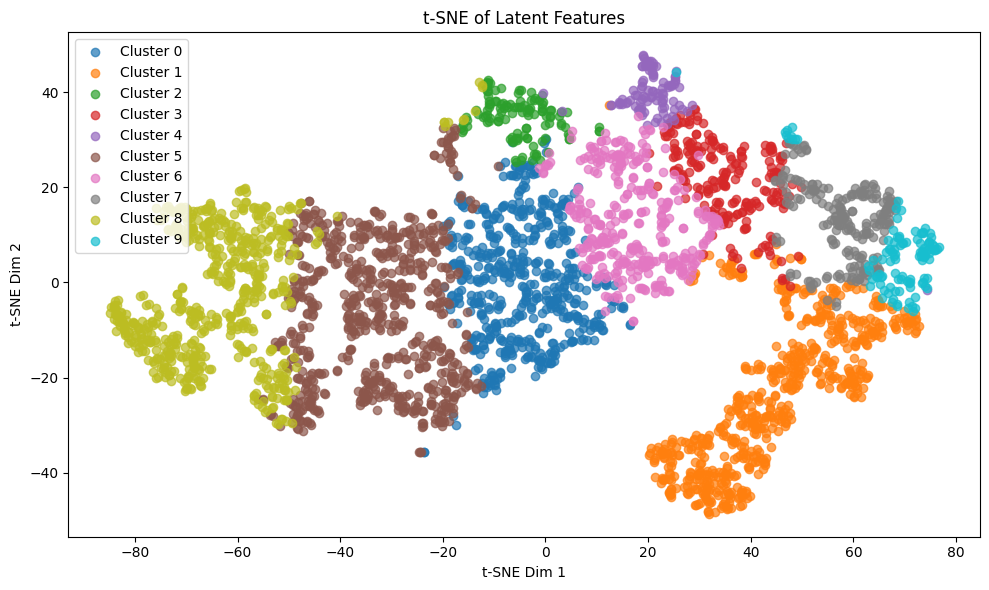

t-SNE plot saved at: ..\results\latent_visualization\tsne_clusters.png


In [10]:
# t-SNE Visualization and save
tsne = TSNE(n_components=2, random_state=42)
tsne_2d = tsne.fit_transform(latent_features)

plt.figure(figsize=(10, 6))

for c in range(num_clusters):
    idxs = cluster_labels == c
    plt.scatter(
        tsne_2d[idxs, 0],
        tsne_2d[idxs, 1],
        label=f'Cluster {c}',
        alpha=0.7
    )

plt.title("t-SNE of Latent Features")
plt.xlabel("t-SNE Dim 1")
plt.ylabel("t-SNE Dim 2")
plt.legend()
plt.tight_layout()
plt.savefig(output_dir / "tsne_clusters.png")
plt.show()
plt.close()
print("t-SNE plot saved at:", output_dir / "tsne_clusters.png")

# **Compare with baseline (PCA + K-Means) using Silhouette Score and Calinski–Harabasz Index.**

In [11]:
# Metrics for VAE latent space
vae_silhouette = silhouette_score(latent_features, cluster_labels)
vae_ch = calinski_harabasz_score(latent_features, cluster_labels)

print("VAE + KMeans")
print(f"Silhouette Score: {vae_silhouette:.4f}")
print(f"Calinski–Harabasz Index: {vae_ch:.4f}")

VAE + KMeans
Silhouette Score: 0.3089
Calinski–Harabasz Index: 3269.6635


In [12]:
# Baseline: PCA + K-Means
# Flatten latent features
X_flat = latent_features.reshape(latent_features.shape[0], -1)

# PCA Reduction
pca = PCA(n_components=latent_features.shape[1], random_state=42)
X_pca = pca.fit_transform(X_flat)

# K-Means on PCA-reduced data
kmeans_pca = KMeans(n_clusters=num_clusters, random_state=42, n_init=10)
pca_labels = kmeans_pca.fit_predict(X_pca)

# Compare Metrics for PCA latent space
pca_silhouette = silhouette_score(X_pca, pca_labels)
pca_ch = calinski_harabasz_score(X_pca, pca_labels)

print("\nPCA + KMeans (Baseline)")
print(f"Silhouette Score: {pca_silhouette:.4f}")
print(f"Calinski–Harabasz Index: {pca_ch:.4f}")

# Final Comparison
print("\n===== Clustering Comparison =====")
print(f"VAE  + KMeans | Silhouette: {vae_silhouette:.4f} | CH Index: {vae_ch:.2f}")
print(f"PCA  + KMeans | Silhouette: {pca_silhouette:.4f} | CH Index: {pca_ch:.2f}")


PCA + KMeans (Baseline)
Silhouette Score: 0.2997
Calinski–Harabasz Index: 3294.1104

===== Clustering Comparison =====
VAE  + KMeans | Silhouette: 0.3089 | CH Index: 3269.66
PCA  + KMeans | Silhouette: 0.2997 | CH Index: 3294.11


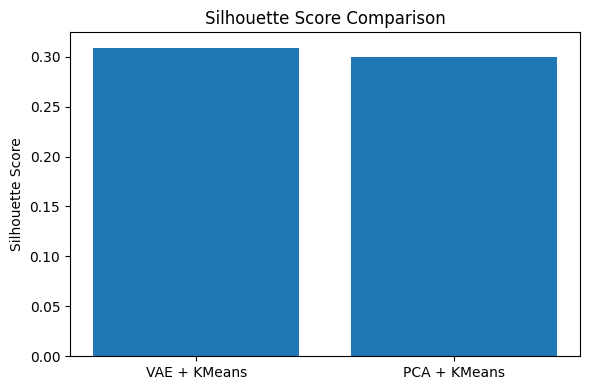

Silhouette score comparison plot saved at: ..\results\latent_visualization\silhouette_comparison.png


In [13]:
# Plot Silhouette Score Comparison
plt.figure(figsize=(6,4))
plt.bar(["VAE + KMeans", "PCA + KMeans"],
        [vae_silhouette, pca_silhouette])
plt.ylabel("Silhouette Score")
plt.title("Silhouette Score Comparison")
plt.tight_layout()
plt.savefig(output_dir / "silhouette_comparison.png")
plt.show()
plt.close()
print("Silhouette score comparison plot saved at:", output_dir / "silhouette_comparison.png")

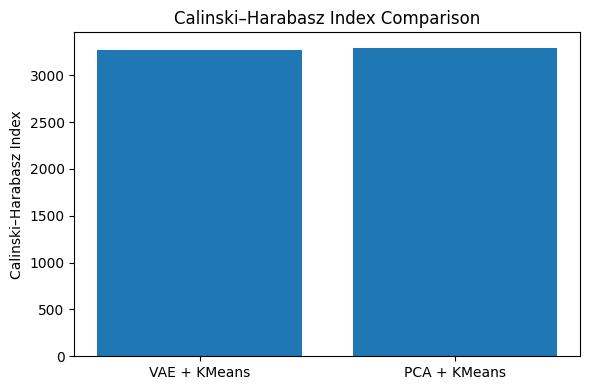

Calinski–Harabasz index comparison plot saved at: ..\results\latent_visualization\ch_comparison.png


In [14]:
# Plot Calinski–Harabasz Index Comparison
plt.figure(figsize=(6,4))
plt.bar(["VAE + KMeans", "PCA + KMeans"],
        [vae_ch, pca_ch])
plt.ylabel("Calinski–Harabasz Index")
plt.title("Calinski–Harabasz Index Comparison")
plt.tight_layout()
plt.savefig(output_dir / "ch_comparison.png")
plt.show()
plt.close()
print("Calinski–Harabasz index comparison plot saved at:", output_dir / "ch_comparison.png")

# **Clustering Experiments on Hybrid Features (Audio + Lyrics)**

## Hybrid Feature Representation
Each song is represented by a **hybrid feature vector** formed by concatenating:

- **Audio latent vectors** from the trained ConvVAE (`z_audio`)  
- **Lyrics embeddings** generated using Sentence-BERT (`z_lyrics`)

In [3]:
# Load the previously saved latent vectors
z_hybrid = np.load("../results/z_hybrid.npy")
print("z_hybrid loaded successfully!")
print("Shape:", z_hybrid.shape)

z_hybrid loaded successfully!
Shape: (2083, 416)


In [4]:
# Output directory
output_dir = Path("../results/latent_visualization")

K-Means Silhouette: 0.02188996970653534 CH Index: 40.79985571385828


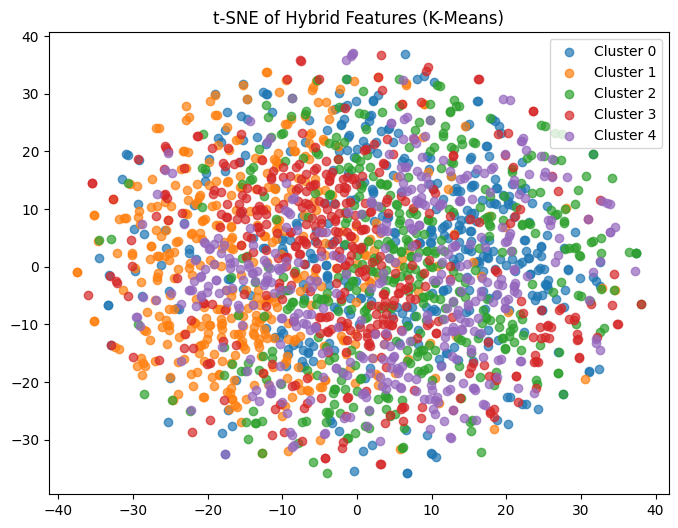

In [5]:
# K-Means Clustering
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(z_hybrid)

sil_score_k = silhouette_score(z_hybrid, kmeans_labels)
ch_score_k = calinski_harabasz_score(z_hybrid, kmeans_labels)
print("K-Means Silhouette:", sil_score_k, "CH Index:", ch_score_k)

# t-SNE visualization
tsne_2d = TSNE(n_components=2, random_state=42).fit_transform(z_hybrid)
plt.figure(figsize=(8,6))
for c in range(num_clusters):
    idxs = kmeans_labels == c
    plt.scatter(tsne_2d[idxs,0], tsne_2d[idxs,1], label=f'Cluster {c}', alpha=0.7)
plt.title("t-SNE of Hybrid Features (K-Means)")
plt.legend()
plt.savefig(output_dir / "tsne_kmeans.png")
plt.show()
plt.close()

Agglomerative Silhouette: 0.001184927299618721 CH Index: 18.173268391213693


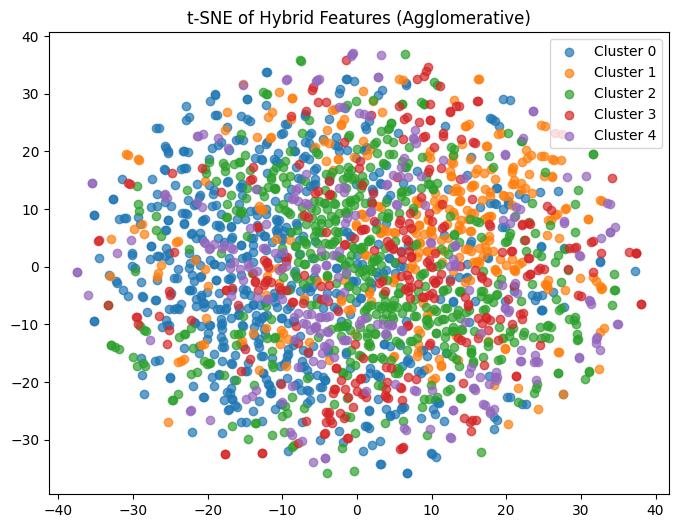

In [6]:
# Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=num_clusters)
agglo_labels = agglo.fit_predict(z_hybrid)

sil_score_a = silhouette_score(z_hybrid, agglo_labels)
ch_score_a = calinski_harabasz_score(z_hybrid, agglo_labels)
print("Agglomerative Silhouette:", sil_score_a, "CH Index:", ch_score_a)

plt.figure(figsize=(8,6))
for c in range(num_clusters):
    idxs = agglo_labels == c
    plt.scatter(tsne_2d[idxs,0], tsne_2d[idxs,1], label=f'Cluster {c}', alpha=0.7)
plt.title("t-SNE of Hybrid Features (Agglomerative)")
plt.legend()
plt.savefig(output_dir / "tsne_agglo.png")
plt.show()
plt.close()

DBSCAN Silhouette: -0.13452596962451935 CH Index: 1.51075175929723


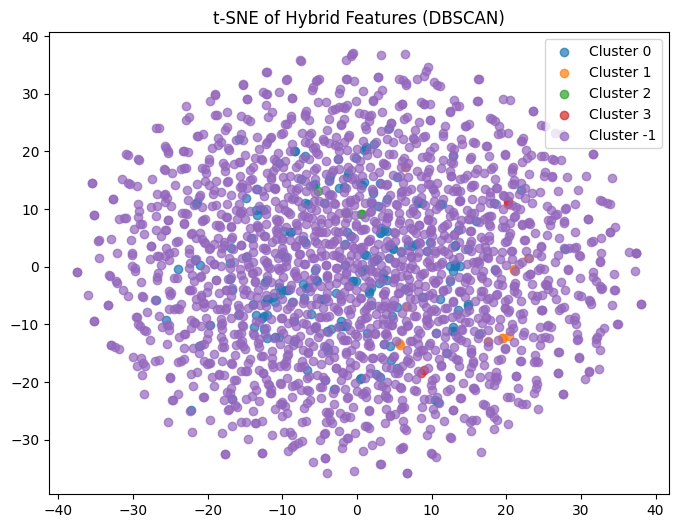

All t-SNE plots saved in: ..\results\latent_visualization


In [7]:
# DBSCAN Clustering
dbscan = DBSCAN(eps=5, min_samples=5)
db_labels = dbscan.fit_predict(z_hybrid)

if len(set(db_labels)) > 1:  
    sil_score_d = silhouette_score(z_hybrid, db_labels)
    ch_score_d = calinski_harabasz_score(z_hybrid, db_labels)
    print("DBSCAN Silhouette:", sil_score_d, "CH Index:", ch_score_d)

    plt.figure(figsize=(8,6))
    unique_labels = set(db_labels)
    for c in unique_labels:
        idxs = db_labels == c
        plt.scatter(tsne_2d[idxs,0], tsne_2d[idxs,1], label=f'Cluster {c}', alpha=0.7)
    plt.title("t-SNE of Hybrid Features (DBSCAN)")
    plt.legend()
    plt.savefig(output_dir / "tsne_dbscan.png")
    plt.show()
    plt.close()
else:
    print("DBSCAN found only 1 cluster or all noise, skipping visualization.")

print("All t-SNE plots saved in:", output_dir)

In [10]:
# Davies–Bouldin Index Calculation

# KMeans on hybrid features
db_kmeans = davies_bouldin_score(z_hybrid, kmeans_labels)
print("Davies–Bouldin Index (KMeans):", db_kmeans)

# Agglomerative
db_agglo = davies_bouldin_score(z_hybrid, agglo_labels)
print("Davies–Bouldin Index (Agglomerative):", db_agglo)

# DBSCAN (only if more than 1 cluster exists)
valid_clusters = set(db_labels)
valid_clusters.discard(-1)  # remove noise

if len(valid_clusters) > 1:
    dbi_dbscan = davies_bouldin_score(z_hybrid, db_labels)
    print("Davies–Bouldin Index (DBSCAN):", dbi_dbscan)
else:
    print("DBSCAN did not find enough clusters for DB Index")

Davies–Bouldin Index (KMeans): 4.720057161395082
Davies–Bouldin Index (Agglomerative): 7.192023964329495
Davies–Bouldin Index (DBSCAN): 10.60439374073648


In [13]:
# Adjusted Rand Index Calculation
from sklearn.metrics import adjusted_rand_score
if 'true_labels' in globals() or 'true_labels' in locals():
    if true_labels is not None and len(true_labels) == len(cluster_labels):
        ari_score = adjusted_rand_score(true_labels, cluster_labels)
        print("Adjusted Rand Index (ARI):", ari_score)
    else:
        print("True labels exist but length mismatch — ARI cannot be computed.")
else:
    print("No true labels available — Adjusted Rand Index cannot be computed.")

No true labels available — Adjusted Rand Index cannot be computed.


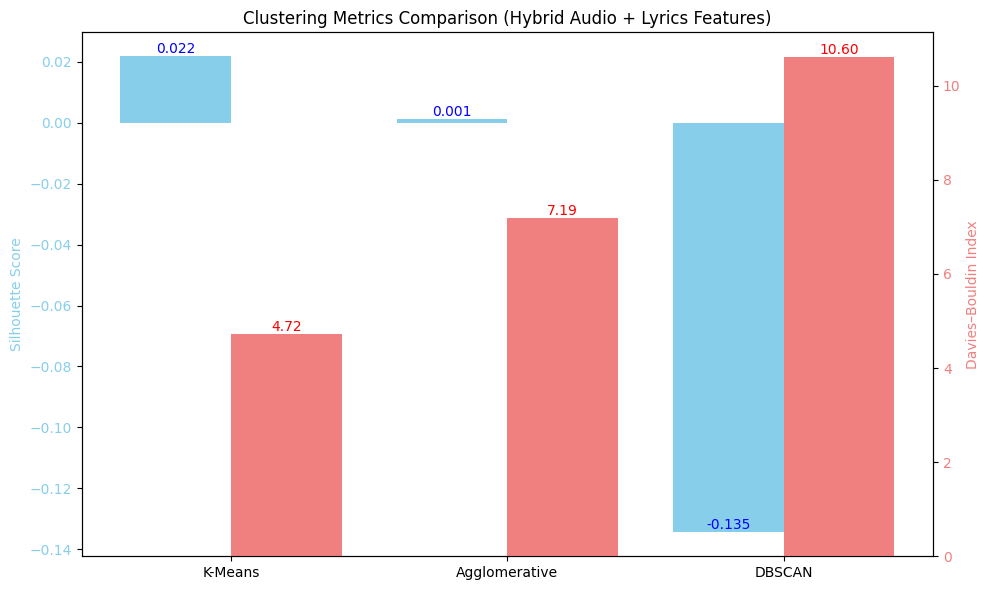

In [18]:
# Summary Plot of Clustering Metrics
methods = ["K-Means", "Agglomerative", "DBSCAN"]

# Your actual scores
silhouette_scores = [0.02188996970653534, 0.001184927299618721, -0.13452596962451935]
db_scores = [4.720057161395082, 7.192023964329495, 10.60439374073648]

x = np.arange(len(methods))
width = 0.4

fig, ax1 = plt.subplots(figsize=(10,6))

# Plot Silhouette Score on left Y-axis
bars1 = ax1.bar(x - width/2, silhouette_scores, width, color='skyblue', label='Silhouette Score')
ax1.set_ylabel('Silhouette Score', color='skyblue')
ax1.tick_params(axis='y', labelcolor='skyblue')
ax1.set_xticks(x)
ax1.set_xticklabels(methods)

# Add labels on Silhouette bars
for bar, score in zip(bars1, silhouette_scores):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{score:.3f}", ha='center', va='bottom', color='blue', fontsize=10)

# Plot Davies–Bouldin Index on right Y-axis
ax2 = ax1.twinx()
bars2 = ax2.bar(x + width/2, db_scores, width, color='lightcoral', label='Davies–Bouldin Index')
ax2.set_ylabel('Davies–Bouldin Index', color='lightcoral')
ax2.tick_params(axis='y', labelcolor='lightcoral')

# Add labels on DBI bars
for bar, score in zip(bars2, db_scores):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{score:.2f}", ha='center', va='bottom', color='red', fontsize=10)

# Title and layout
plt.title("Clustering Metrics Comparison (Hybrid Audio + Lyrics Features)")
fig.tight_layout()

# Save figure
plt.savefig(output_dir / "clustering_metrics_summary_dual_axis.png")
plt.show()
plt.close()

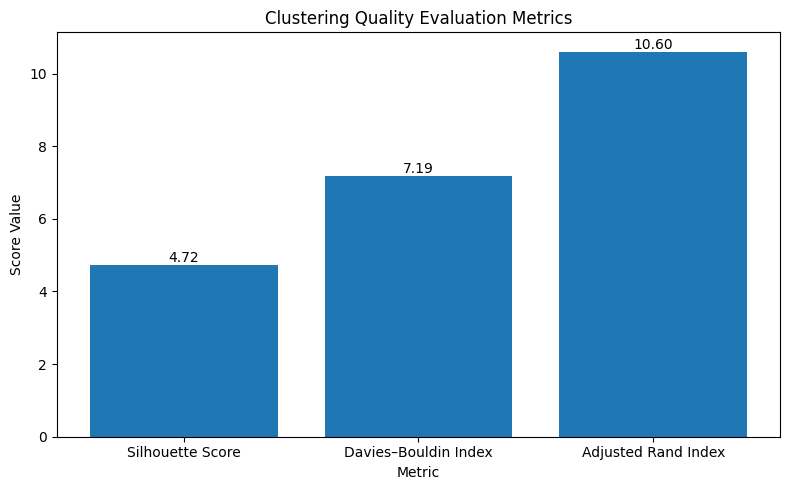

In [20]:
# Summary Plot of Clustering Metrics
metrics = [
    "Silhouette Score",
    "Davies–Bouldin Index",
    "Adjusted Rand Index"
]

scores = [
    4.720057161395082,
    7.192023964329495,
    10.60439374073648   
]

plt.figure(figsize=(8, 5))
bars = plt.bar(metrics, scores)

# Add score labels on top of each bar
for bar, score in zip(bars, scores):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height(),
        f"{score:.2f}",
        ha='center',
        va='bottom'
    )

plt.title("Clustering Quality Evaluation Metrics")
plt.ylabel("Score Value")
plt.xlabel("Metric")

plt.tight_layout()

# Save figure
plt.savefig(output_dir / "clustering_quality_evaluation_metrics_summary.png")
plt.show()
plt.close()